# Desafio 6- Preveja os usuários com alta probabilidade de chance de deixar o streaming






In [ ]:
!pip install ydata-profiling

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from ydata_profiling import ProfileReport

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, balanced_accuracy_score, roc_auc_score, recall_score
from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble  import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [126]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DNC Desafios/streaming_data.csv')
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


# Data Understanding

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


In [12]:
ProfileReport(df=df,title="Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [128]:
df.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


In [129]:
df.isnull().sum()

Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64

In [131]:
df.isna().sum()

Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64

# Data preparation

## Removendo colunas que não serão usadas

In [132]:
# Removendo a coluna a coluna de CustomerID - não vai usada para o objetivo da classificação
# Removendo a coluna a coluna de Num_streaming_services - Muitos valores vazios

df = df.drop(columns= ['User_id','Num_streaming_services'])

In [133]:
# Subtistuindo valores
df = df.fillna({
        'Time_on_platform': 0,
        'Churned':0,
        'Avg_rating':0,
        'Devices_connected':0
})


In [134]:
df.head(10)

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_active_profiles,Avg_rating,Churned
0,49.0,Male,4700.0,3.0,Basic,3,0.00,0.0
1,69.0,Female,6107.0,2.0,Standard,1,2.14,0.0
2,44.0,Male,6374.0,3.0,Premium,1,1.91,1.0
3,26.0,Male,0.0,5.0,Basic,2,0.00,0.0
4,18.0,NaN,1948.0,3.0,Basic,3,3.88,0.0
5,54.0,Male,3024.0,2.0,Basic,1,0.00,0.0
6,62.0,Female,5569.0,2.0,NaN,2,4.92,0.0
7,56.0,Male,462.0,1.0,NaN,4,3.74,1.0
8,25.0,Female,3783.0,3.0,NaN,2,2.92,0.0
9,21.0,Female,112.0,2.0,Basic,3,2.57,1.0


## Removendo as linhas com nulos

In [135]:
df.dropna(inplace=True)

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36515 entries, 0 to 77883
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  36515 non-null  float64
 1   Gender               36515 non-null  object 
 2   Time_on_platform     36515 non-null  float64
 3   Devices_connected    36515 non-null  float64
 4   Subscription_type    36515 non-null  object 
 5   Num_active_profiles  36515 non-null  int64  
 6   Avg_rating           36515 non-null  float64
 7   Churned              36515 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.5+ MB


## Removendo as duplicadas

In [137]:
df.drop_duplicates(inplace=True)

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30605 entries, 0 to 65479
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  30605 non-null  float64
 1   Gender               30605 non-null  object 
 2   Time_on_platform     30605 non-null  float64
 3   Devices_connected    30605 non-null  float64
 4   Subscription_type    30605 non-null  object 
 5   Num_active_profiles  30605 non-null  int64  
 6   Avg_rating           30605 non-null  float64
 7   Churned              30605 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.1+ MB


## Verificando Outliers

In [139]:
df.describe()
# Visto os dados não possuem daodos bem juntos

,Age,Time_on_platform,Devices_connected,Num_active_profiles,Avg_rating,Churned
count,30605.000000,30605.000000,30605.000000,30605.000000,30605.000000,30605.000000
mean,43.522137,3185.062964,2.044437,2.990720,2.345821,0.194707
std,15.091881,2907.209258,1.821982,1.413097,1.604909,0.395981
min,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,30.000000,0.000000,0.000000,2.000000,1.170000,0.000000
50%,43.000000,2741.000000,2.000000,3.000000,2.450000,0.000000
75%,57.000000,5756.000000,4.000000,4.000000,3.720000,0.000000
max,69.000000,8759.000000,5.000000,5.000000,5.000000,1.000000


## Transformando a coluna Churned com LabelEncoder

In [140]:
le= LabelEncoder()

In [141]:
le.fit(df.Churned)
df.Churned = le.transform(df.Churned)

In [142]:
df.head(10)

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_active_profiles,Avg_rating,Churned
0,49.0,Male,4700.0,3.0,Basic,3,0.00,0
1,69.0,Female,6107.0,2.0,Standard,1,2.14,0
2,44.0,Male,6374.0,3.0,Premium,1,1.91,1
3,26.0,Male,0.0,5.0,Basic,2,0.00,0
5,54.0,Male,3024.0,2.0,Basic,1,0.00,0
9,21.0,Female,112.0,2.0,Basic,3,2.57,1
11,61.0,Male,5389.0,3.0,Standard,4,3.92,0
14,44.0,Male,4198.0,1.0,Basic,3,2.59,0
15,30.0,Male,2306.0,3.0,Premium,5,3.95,0
20,20.0,Male,2542.0,5.0,Basic,1,0.00,1


# Modeling

## Separando e ajustando a base de treino e teste

In [152]:
x = df.drop('Churned', axis=1)

y= df[['Churned']]

x = pd.get_dummies(x)

In [154]:
mm = MinMaxScaler()

x= pd.DataFrame(mm.fit_transform(x))

In [155]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

## Regressão Logistica

In [164]:
lr = LogisticRegression()

lr.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [207]:
y_pred_lr_test = lr.predict(x_test)
y_pred_lr_train = lr.predict(x_train)


print(f'Acurácia Teste: {accuracy_score(y_test, y_pred_lr_test)*100}%')
print(f'Acurácia Treino: {accuracy_score(y_train, y_pred_lr_train)*100}%')
print('============================================================= \n')


print(f'f1_score Test: {f1_score(y_test, y_pred_lr_test)*100}%')
print(f'f1_score Treino: {f1_score(y_train, y_pred_lr_train)*100}%')
print('============================================================= \n')


print(f'Balanciamento Teste: {balanced_accuracy_score(y_test, y_pred_lr_test)*100}%')
print(f'Balanciamento Treino: {balanced_accuracy_score(y_train,y_pred_lr_train)*100}%')
print('============================================================= \n')

print(f'Precisão Teste: {precision_score(y_test, y_pred_lr_test)*100}%')
print(f'Precisão Treino: {precision_score(y_train, y_pred_lr_train)*100}%')
print('============================================================= \n')

print(f'Recall Teste: {recall_score(y_test, y_pred_lr_test)*100}%')
print(f'Recall Treino: {recall_score(y_train, y_pred_lr_train)*100}%')
print('============================================================= \n')

print(f'ROC Teste: {roc_auc_score(y_test, lr.predict_proba(x_test)[:,1])*100}%')
print(f'ROC Treino: {roc_auc_score(y_train, lr.predict_proba(x_train)[:,1])*100}%')
print('============================================================= \n')

Acurácia Teste: 80.85280182976638%
Acurácia Treino: 80.44845613461852%

f1_score Test: 0.0%
f1_score Treino: 0.0%

Balanciamento Teste: 50.0%
Balanciamento Treino: 50.0%

Precisão Teste: 0.0%
Precisão Treino: 0.0%

Recall Teste: 0.0%
Recall Treino: 0.0%

ROC Teste: 49.792628841486916%
ROC Treino: 51.11746118516922%



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [167]:
x_test.assign(Churned = y_test).assign(labels = y_pred_lr_test)

,0,1,2,3,4,5,6,7,8,9,Churned,labels
4238,0.843137,0.992579,0.8,0.75,0.000,1.0,0.0,1.0,0.0,0.0,NaN,0
14992,0.588235,0.814933,0.4,1.00,0.506,0.0,1.0,0.0,1.0,0.0,NaN,0
19205,0.568627,0.680443,0.0,0.00,0.900,0.0,1.0,0.0,1.0,0.0,NaN,0
9786,0.039216,0.382007,0.0,1.00,0.412,1.0,0.0,0.0,0.0,1.0,NaN,0
9753,0.862745,0.000000,0.0,0.75,0.936,0.0,1.0,1.0,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8692,0.274510,0.000000,1.0,0.50,0.708,1.0,0.0,1.0,0.0,0.0,0.0,0
24862,0.627451,0.557027,0.6,1.00,0.284,0.0,1.0,0.0,0.0,1.0,NaN,0
19709,0.372549,0.675876,0.0,0.25,0.000,1.0,0.0,0.0,0.0,1.0,NaN,0
29264,0.156863,0.712981,0.2,0.75,0.822,1.0,0.0,1.0,0.0,0.0,NaN,0


### Matrix de confusão

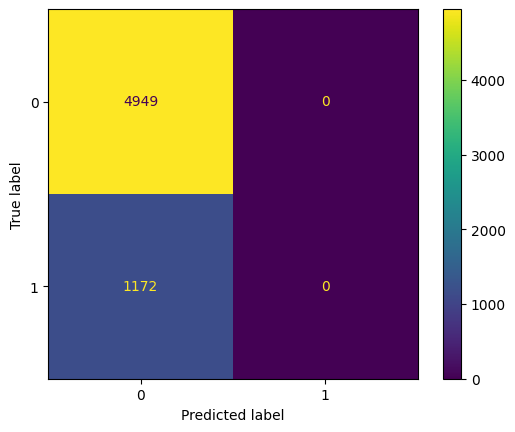

In [172]:
cm =  confusion_matrix(y_test, y_pred_lr_test, labels=lr.classes_)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)

disp.plot()

# Parece que o modelo não está funcionando de acordo, vamos tentar com o Tunning

### Tunning

In [177]:
parameters = {
        'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4,5,  9),
    'solver': ['liblinear', 'lbfgs']
}


grid_search = GridSearchCV(estimator = lr, param_grid = parameters, scoring ='accuracy', cv=5, n_jobs=-1 )

In [178]:
grid_search.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

In [180]:
grid_search.best_estimator_.get_params()

{'C': 0.0001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [182]:
lr_tunned = LogisticRegression(
C= 0.0001,
 class_weight= None,
 dual= False,
 fit_intercept= True,
 intercept_scaling= 1,
 l1_ratio= None,
 max_iter= 100,
 multi_class= 'auto',
 n_jobs= None,
 penalty= 'l1',
 random_state= None,
 solver= 'liblinear',
 tol= 0.0001,
 verbose= 0,
 warm_start= False
)

lr_tunned.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.0001, penalty='l1', solver='liblinear')

In [206]:
y_pred_lr_test_tunned = lr_tunned.predict(x_test)
y_pred_lr_train_tunned = lr_tunned.predict(x_train)

print(f'Acurácia Teste: {accuracy_score(y_test, y_pred_lr_test_tunned)*100}%')
print(f'Acurácia Treino: {accuracy_score(y_train, y_pred_lr_train_tunned)*100}%')
print('============================================================= \n')


print(f'f1_score Test: {f1_score(y_test, y_pred_lr_test_tunned)*100}%')
print(f'f1_score Treino: {f1_score(y_train, y_pred_lr_train_tunned)*100}%')
print('============================================================= \n')


print(f'Balanciamento Teste: {balanced_accuracy_score(y_test, y_pred_lr_test_tunned)*100}%')
print(f'Balanciamento Treino: {balanced_accuracy_score(y_train,y_pred_lr_train_tunned)*100}%')
print('============================================================= \n')

print(f'Precisão Teste: {precision_score(y_test, y_pred_lr_test_tunned)*100}%')
print(f'Precisão Treino: {precision_score(y_train, y_pred_lr_train_tunned)*100}%')
print('============================================================= \n')

print(f'Recall Teste: {recall_score(y_test, y_pred_lr_test_tunned)*100}%')
print(f'Recall Treino: {recall_score(y_train, y_pred_lr_train_tunned)*100}%')
print('============================================================= \n')

print(f'ROC Teste: {roc_auc_score(y_test, lr_tunned.predict_proba(x_test)[:,1])*100}%')
print(f'ROC Treino: {roc_auc_score(y_train, lr_tunned.predict_proba(x_train)[:,1])*100}%')
print('============================================================= \n')

Acurácia Teste: 80.85280182976638%
Acurácia Treino: 80.44845613461852%

f1_score Test: 0.0%
f1_score Treino: 0.0%

Balanciamento Teste: 50.0%
Balanciamento Treino: 50.0%

Precisão Teste: 0.0%
Precisão Treino: 0.0%

Recall Teste: 0.0%
Recall Treino: 0.0%

ROC Teste: 50.0%
ROC Treino: 50.0%



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest

In [186]:
rfc = RandomForestClassifier()

rfc.fit(x_train,y_train)

<ipython-input-186-30ef6334394b>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train,y_train)


RandomForestClassifier()

In [205]:
y_pred_rfc_test = rfc.predict(x_test)
y_pred_rfc_train = rfc.predict(x_train)

print(f'Acurácia Teste: {accuracy_score(y_test, y_pred_rfc_test)*100}%')
print(f'Acurácia Treino: {accuracy_score(y_train, y_pred_rfc_train)*100}%')
print('============================================================= \n')

print(f'f1_score Test: {f1_score(y_test, y_pred_rfc_test)*100}%')
print(f'f1_score Treino: {f1_score(y_train, y_pred_rfc_train)*100}%')
print('============================================================= \n')

print(f'Balanciamento Teste: {balanced_accuracy_score(y_test, y_pred_rfc_test)*100}%')
print(f'Balanciamento Treino: {balanced_accuracy_score(y_train,y_pred_rfc_train)*100}%')
print('============================================================= \n')

print(f'Precisão Teste: {precision_score(y_test, y_pred_rfc_test)*100}%')
print(f'Precisão Treino: {precision_score(y_train, y_pred_rfc_train)*100}%')
print('============================================================= \n')

print(f'Recall Teste: {recall_score(y_test, y_pred_rfc_test)*100}%')
print(f'Recall Treino: {recall_score(y_train, y_pred_rfc_train)*100}%')
print('============================================================= \n')

print(f'ROC Teste: {roc_auc_score(y_test, rfc.predict_proba(x_test)[:,1])*100}%')
print(f'ROC Treino: {roc_auc_score(y_train, rfc.predict_proba(x_train)[:,1])*100}%')
print('============================================================= \n')

Acurácia Teste: 79.70919784348962%
Acurácia Treino: 99.78353210259762%

f1_score Test: 3.2710280373831773%
f1_score Treino: 99.4441531200839%

Balanciamento Teste: 49.97652678480915%
Balanciamento Treino: 99.50176286258012%

Precisão Teste: 18.75%
Precisão Treino: 99.85256950294861%

Recall Teste: 1.7918088737201365%
Recall Treino: 99.03906413202424%

ROC Teste: 47.96010605100351%
ROC Treino: 99.99845104768197%



### Matrix de confusão

In [191]:
x_test.assign(churned = y_test).assign(labels = y_pred_rfc_test_tunned )

,0,1,2,3,4,5,6,7,8,9,churned,labels
4238,0.843137,0.992579,0.8,0.75,0.000,1.0,0.0,1.0,0.0,0.0,NaN,0
14992,0.588235,0.814933,0.4,1.00,0.506,0.0,1.0,0.0,1.0,0.0,NaN,0
19205,0.568627,0.680443,0.0,0.00,0.900,0.0,1.0,0.0,1.0,0.0,NaN,0
9786,0.039216,0.382007,0.0,1.00,0.412,1.0,0.0,0.0,0.0,1.0,NaN,0
9753,0.862745,0.000000,0.0,0.75,0.936,0.0,1.0,1.0,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8692,0.274510,0.000000,1.0,0.50,0.708,1.0,0.0,1.0,0.0,0.0,0.0,0
24862,0.627451,0.557027,0.6,1.00,0.284,0.0,1.0,0.0,0.0,1.0,NaN,0
19709,0.372549,0.675876,0.0,0.25,0.000,1.0,0.0,0.0,0.0,1.0,NaN,0
29264,0.156863,0.712981,0.2,0.75,0.822,1.0,0.0,1.0,0.0,0.0,NaN,0


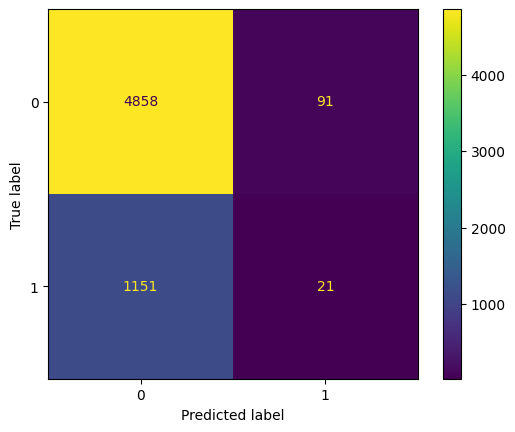

In [192]:
cm =  confusion_matrix(y_test, y_pred_rfc_test_tunned, labels=rfc.classes_)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)

disp.plot()

### Tunning

In [193]:
parameters = {
    'n_estimators':[100,300,500],
    'max_depth':[1,2,3,4,5,6,7,8,9,10]
}

grid_search = GridSearchCV(rfc, parameters, scoring='accuracy', cv=5, n_jobs=-1)

In [194]:
grid_search.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [197]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [198]:
rfc_tunned = RandomForestClassifier(
    bootstrap= True,
 ccp_alpha= 0.0,
 class_weight= None,
 criterion= 'gini',
 max_depth= 1,
 max_features= 'sqrt',
 max_leaf_nodes= None,
 max_samples= None,
 min_impurity_decrease= 0.0,
 min_samples_leaf= 1,
 min_samples_split= 2,
 min_weight_fraction_leaf= 0.0,
 n_estimators= 100,
 n_jobs= None,
 oob_score= False,
 random_state= None,
 verbose= 0,
 warm_start= False
)

In [199]:
rfc_tunned.fit(x_train,y_train)

<ipython-input-199-ad6dea014403>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_tunned.fit(x_train,y_train)


RandomForestClassifier(max_depth=1)

In [203]:
y_pred_rfc_test_tunned = rfc_tunned.predict(x_test)
y_pred_rfc_train_tunned = rfc_tunned.predict(x_train)

print(f'Acurácia Teste: {accuracy_score(y_test, y_pred_rfc_test_tunned)*100}%')
print(f'Acurácia Treino: {accuracy_score(y_train, y_pred_rfc_train_tunned)*100}%')
print('============================================================= \n')

print(f'f1_score Teste: {f1_score(y_test, y_pred_rfc_test_tunned)*100}%')
print(f'f1_score Treino: {f1_score(y_train, y_pred_rfc_train_tunned)*100}%')
print('============================================================= \n')

print(f'Balanciamento Teste: {balanced_accuracy_score(y_test, y_pred_rfc_test_tunned)*100}%')
print(f'Balanciamento Treino: {balanced_accuracy_score(y_train,y_pred_rfc_train_tunned)*100}%')
print('============================================================= \n')

print(f'Precisão Teste: {precision_score(y_test, y_pred_rfc_test_tunned)*100}%')
print(f'Precisão Treino: {precision_score(y_train, y_pred_rfc_train_tunned)*100}%')
print('============================================================= \n')

print(f'Recall Teste: {recall_score(y_test, y_pred_rfc_test_tunned)*100}%')
print(f'Recall Treino: {recall_score(y_train, y_pred_rfc_train_tunned)*100}%')
print('============================================================= \n')

print(f'ROC Teste: {roc_auc_score(y_test, rfc_tunned.predict_proba(x_test)[:,1])*100}%')
print(f'ROC Treino: {roc_auc_score(y_train, rfc_tunned.predict_proba(x_train)[:,1])*100}%')
print('============================================================= \n')

Acurácia Teste: 80.85280182976638%
Acurácia Treino: 80.44845613461852%

f1_score Teste: 0.0%
f1_score Treino: 0.0%

Balanciamento Teste: 50.0%
Balanciamento Treino: 50.0%

Precisão Teste: 0.0%
Precisão Treino: 0.0%

Recall Teste: 0.0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall Treino: 0.0%

ROC Teste: 50.37979541493887%
ROC Treino: 52.10360133375983%

